# Plotting gridded DBPM outputs
**Author**: Denisse Fierro Arcos  
**Date**: 2025-02-06  

In this notebook, we will create a variety of plots using the outputs of gridded DBPM runs.

## Loading relevant libraries

In [119]:
import os
os.chdir('/g/data/vf71/la6889/lme_scale_calibration_ISMIP3a/new_workflow/')
from glob import glob
import xarray as xr
import json
import numpy as np
import matplotlib.pyplot as plt
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
# import useful_functions as uf
from dask.distributed import Client

## Start a cluster for parallelisation

In [2]:
client = Client(threads_per_worker = 1)

## Defining basic variables to run gridded DBPM

In [2]:
#Name of region and model resolution
region = 'fao-88'
model_res = '025deg'

#Defining input and output folders
base_folder = '/g/data/vf71/la6889/dbpm_inputs/west_antarctica/'
gridded_outputs = os.path.join(base_folder, 'run_fishing', model_res)
plot_folder = os.path.join(base_folder, 'gridded_run_plots', model_res)
#If output folder does not exist, it will create it
os.makedirs(plot_folder, exist_ok = True) 

## Loading gridded parameters and biomass data

In [81]:
#Loading gridded parameters
gridded_params = json.load(open(
    os.path.join(base_folder, 'gridded_params', model_res,
                 f'dbpm_gridded_size_params_{region}_python.json')))

predators = xr.open_mfdataset(glob(
    os.path.join(gridded_outputs, 'predators*')))['predators']

detritivores = xr.open_mfdataset(glob(
    os.path.join(gridded_outputs, 'detritivores*')))['detritivores']

#Size class bins
log10_size_bins_mat = xr.open_zarr('outputs/log10_size_bins_matrix.zarr/')['size_bins']
size_bin_vals = 10**log10_size_bins_mat

## Subset biomass data 
Selecting relevant size classes for each group.

In [85]:
pred_summ = predators.isel(size_class = slice(gridded_params['ind_min_pred_size'], None)) 
det_summ = detritivores.isel(size_class = 
                             slice(gridded_params['ind_min_detritivore_size'], None)) 

## Preparing data before plotting 

### Option 1: Size spectrum from last available time step 

In [83]:
#Biomass is summed across area of interest
pred_summ = np.log10(pred_summ.isel(time = -1).sum(('lat', 'lon')))
dwt_summ = np.log10(det_summ.isel(time = -1).sum(('lat', 'lon')))

### Option 2: Size spectrum from mean values across all timesteps 

In [86]:
pred_summ = np.log10(pred_summ.mean('time').sum(('lat', 'lon')))
det_summ = np.log10(det_summ.mean('time').sum(('lat', 'lon')))

## Plotting size spectrum 

Text(0.04, 0.1, 'benthic prey preference: 0')

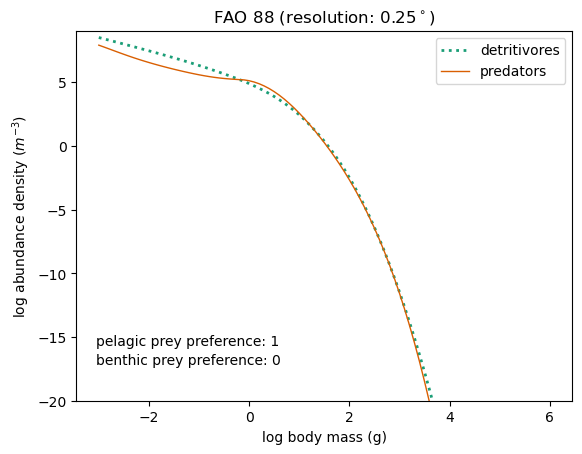

In [87]:
#Initialise figure
fig = plt.figure()
ax = fig.add_subplot()

#Plot detritivore and predator biomass
det_summ.plot(ax = ax, color = '#1b9e77', ls = 'dotted', lw = 2, 
              label = 'detritivores')
pred_summ.plot(ax = ax, color = '#d95f02', lw = 1, label = 'predators')

#Changing axes labels
ax.set_xlabel('log body mass (g)')
ax.set_ylabel('log abundance density ($m^{-3}$)')

#Adding legend
ax.legend(loc = 'upper right', frameon = True)

#Adding title
#Reformat region variable to use in title
reg_clean = region.upper().replace('-', ' ')
#Adding resolution to title
if model_res == '025deg':
    ax.set_title(f'{reg_clean} (resolution: 0.25$^\circ$)')
elif model_res == '1deg':
    ax.set_title(f'{reg_clean} (resolution: 1$^\circ$)')

#Setting minimum and maximum values along y axis
plt.ylim(-20, np.ceil(pred_summ.max().values)+1)

#Adding text
ax.text(0.04, 0.15, 'pelagic prey preference: 1', transform = ax.transAxes)
ax.text(0.04, 0.1, 'benthic prey preference: 0', transform = ax.transAxes)

#Saving plot
fn = f'size_spectrum_{region}_{model_res}.png'
plt.savefig(os.path.join(plot_folder, fn), dpi = 300, bbox_inches = 'tight', 
            pad_inches = 0.05)

## Calculate total biomass for `predators` and `detritivores` 

In [96]:
tot_pred_bio = ((predators.isel(size_class = slice(gridded_params['ind_min_pred_size'], 
                                                  None))*
                gridded_params['log_size_increase']*size_bin_vals).
                sum('size_class')).groupby('time.year').mean('time')

tot_pred_det = (detritivores.isel(size_class = 
                                  slice(gridded_params['ind_min_detritivore_size'], 
                                        None))*gridded_params['log_size_increase']*
                size_bin_vals).sum('size_class').groupby('time.year').mean('time')

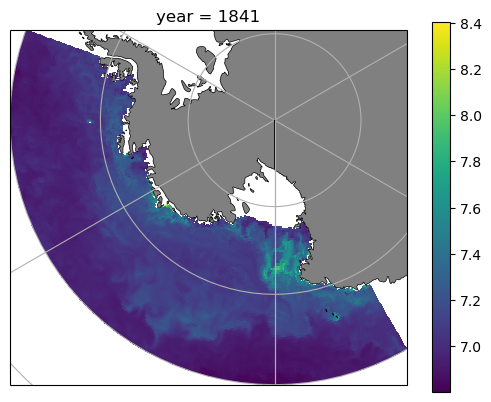

In [126]:
#Initialise figure
fig = plt.figure()
ax = fig.add_subplot(projection = ccrs.SouthPolarStereo())

#Land mask
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', 
                                   facecolor = 'gray', linewidth = 0.5)

#Plot first year
tot_pred_bio.where(tot_pred_bio != 0).isel(year = 0).plot(ax = ax, 
                                                          transform = ccrs.PlateCarree())

ax.add_feature(land_50m)
ax.gridlines()

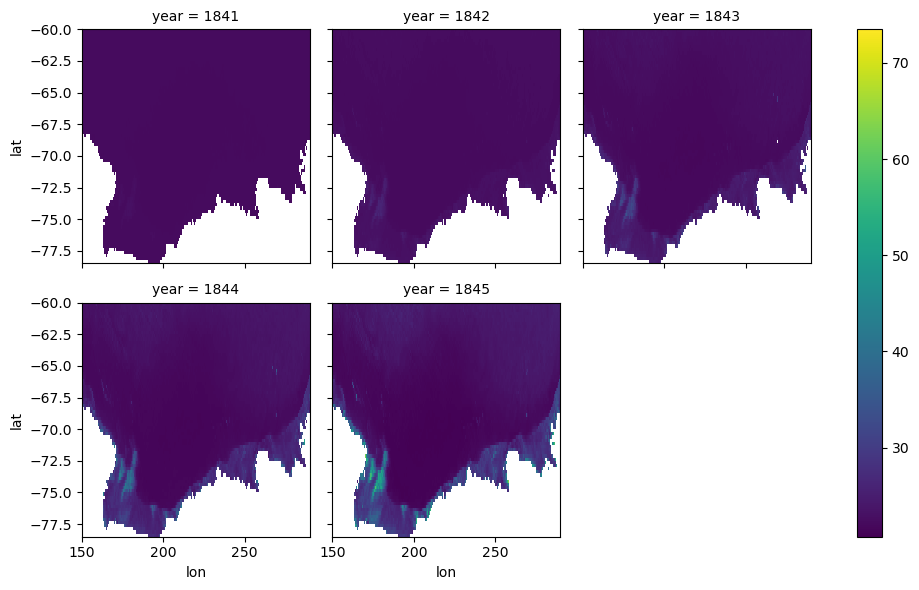

In [103]:
tot_pred_det.where(tot_pred_det != 0).plot(col = 'year', col_wrap = 3)